# CNN for Alzheimer's disease detection

The CNN is trained to detect Alzheimer's disease. Given an MRI image of the brain, the CNN can classify it in one for the following classes based on severity  
1. MildDemented
2. VeryMildDemented
3. NonDemented
4. ModerateDemeneted
   
It is trained on "Alzheimer's Dataset ( 4 class of Images)" dataset from [kaggle](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images) which contains total of ~6000 images for 4 severity classes.

In [8]:
import torch, torchvision, matplotlib

print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("matplotlib", matplotlib.__version__)

torch 2.1.0
torchvision 0.16.0
matplotlib 3.8.1


# Dataset

The alzheimer's dataset from kaggle is downloaded and extracted in `datasets/alherimers` folder in this repository. The dataset is structured in below manner. Images for each severity class are present in their individual folders. 

```
datasets/alzheimers/
├── test
│   ├── MildDemented
│   │   ├── 26 (19).jpg
│   │   ├── .......
│   │   └── 32.jpg
│   ├── ModerateDemented
│   │   ├── 27 (2).jpg
│   │   ├── .......
│   │   └── 32.jpg
│   ├── NonDemented
│   │   ├── 26 (100).jpg
│   │   ├── .......
│   │   └── 32.jpg
│   └── VeryMildDemented
│       ├── 26 (44).jpg
│       ├── .......
│       └── 32.jpg
└── train
    ├── MildDemented
    │   ├── mildDem229.jpg
    │   ├── .......
    │   └── mildDem99.jpg
    ├── ModerateDemented
    │   ├── moderateDem0.jpg
    │   ├── .......
    │   └── moderateDem9.jpg
    ├── NonDemented
    │   ├── nonDem0.jpg
    │   ├── .......
    │   └── nonDem999.jpg
    └── VeryMildDemented
        ├── verymildDem0.jpg
        ├── .......
        └── verymildDem999.jpg

11 directories, 6400 files
```

## Pre-process and load dataset

Each image in dataset is a single channel(grayscale) image of size `176x208` pixels. We will resize it to `150x150` and load it using pytorch datasets utilities. 

Note: Resizing image to smaller size will reduce the model parameters and training time and since our CNN is doing a simple task, it will not impact the accuracy much. 

In [42]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

#train and test data directory
train_data_dir = "./datasets/alzheimers/train"
test_data_dir = "./datasets/alzheimers/test"


#load the train and test data
#transforms.Grayscale(num_output_channels=1),
train_dataset = ImageFolder(
            train_data_dir,
            transform = transforms.Compose([
                transforms.Resize((150,150)),
                transforms.ToTensor(),
                transforms.Grayscale(num_output_channels=1)
            ])
          )

test_dataset = ImageFolder(
                test_data_dir,
                transforms.Compose([
                    transforms.Resize((150,150)),
                    transforms.ToTensor(),
                    transforms.Grayscale(num_output_channels=1)
                ])
               )

In [43]:
print("Training dataset")
print("Type: ", type(train_dataset))
print("Len: ", len(train_dataset))
print("Classes: ",train_dataset.classes)
print("")

print("Test dataset")
print("Type: ", type(test_dataset))
print("Len: ", len(test_dataset))
print("Classes: ",test_dataset.classes)
print("")

print("Single data/image from dataset")
print("Type: ", type(train_dataset[0]))
print("Len: ", len(train_dataset[0]))
print("Data: ", train_dataset[0])
#img, label = train_dataset[0]
print("")

Training dataset
Type:  <class 'torchvision.datasets.folder.ImageFolder'>
Len:  5121
Classes:  ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

Test dataset
Type:  <class 'torchvision.datasets.folder.ImageFolder'>
Len:  1279
Classes:  ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

Single data/image from dataset
Type:  <class 'tuple'>
Len:  2
Data:  (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 0)



Label : MildDemented
Size : torch.Size([1, 150, 150])


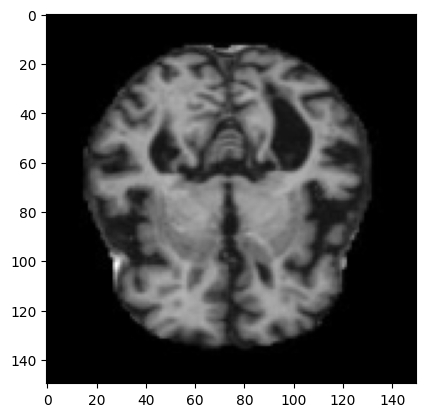

In [44]:
import matplotlib.pyplot as plt
img, label = train_dataset[0]
print("Label :", train_dataset.classes[label])
print("Size :", img.shape)

#display the image
plt.imshow(img.permute(1,2,0), cmap = plt.cm.gray)

## Prep data for training and testing

We will split the dataset into batches of 128 images each using pytorch dataloader utilities. 

In [45]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128

#load the train and validation into batches.
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size, num_workers = 2, pin_memory = True)

print("Batch size: ", batch_size)
print("Number of train data batches: ", len(train_dl))
print("Number of test data batches: ", len(test_dl))

Batch size:  128
Number of train data batches:  41
Number of test data batches:  10


# CNN Model

In [46]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,4)
        )

    def forward(self, xb):
        return self.network(xb)

# Training

In [52]:
# https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/
# https://github.com/patrickloeber/pytorchTutorial/blob/master/14_cnn.py
import time

num_epochs = 5
learning_rate = 0.01

model = CNN()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print('Training Started....')
n_total_steps = len(train_dl)
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    for i, (images, labels) in enumerate(train_dl):
        step_start_time = time.time()
        
        # images.shape : [128, 1, 150, 150]
        # labels.shape: [128]
        images = images.to()
        labels = labels.to()

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, Time: {time.time()-step_start_time:.4f}s')
    print(f'Epoch [{epoch+1}/{num_epochs}], Time: {time.time()-epoch_start_time:.4f}s')

print('Finished Training')

Training Started....
Epoch [1/5], Step [1/41], Loss: 1.3733, Time: 8.9939s
Epoch [1/5], Step [2/41], Loss: 1.3737, Time: 8.4005s
Epoch [1/5], Step [3/41], Loss: 1.3707, Time: 8.4261s
Epoch [1/5], Step [4/41], Loss: 1.3700, Time: 8.3235s
Epoch [1/5], Step [5/41], Loss: 1.3661, Time: 8.2894s
Epoch [1/5], Step [6/41], Loss: 1.3639, Time: 8.2636s
Epoch [1/5], Step [7/41], Loss: 1.3587, Time: 8.2537s
Epoch [1/5], Step [8/41], Loss: 1.3599, Time: 8.2126s
Epoch [1/5], Step [9/41], Loss: 1.3548, Time: 8.3571s
Epoch [1/5], Step [10/41], Loss: 1.3549, Time: 8.2383s
Epoch [1/5], Step [11/41], Loss: 1.3522, Time: 8.2499s
Epoch [1/5], Step [12/41], Loss: 1.3539, Time: 8.2421s
Epoch [1/5], Step [13/41], Loss: 1.3466, Time: 8.1916s
Epoch [1/5], Step [14/41], Loss: 1.3471, Time: 8.1845s
Epoch [1/5], Step [15/41], Loss: 1.3422, Time: 8.2107s
Epoch [1/5], Step [16/41], Loss: 1.3450, Time: 8.2077s
Epoch [1/5], Step [17/41], Loss: 1.3379, Time: 8.2083s
Epoch [1/5], Step [18/41], Loss: 1.3356, Time: 8.1930

### Save model (donot run)

In [59]:
PATH = 'cnn.pth'
torch.save(model.state_dict(), PATH)

# Validation/Testing

In [61]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(4)]
    n_class_samples = [0 for i in range(4)]
    for images, labels in train_dl:
        images = images.to()
        labels = labels.to()
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        #print(outputs, predicted)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            if i < len(labels):
              label = labels[i]
              pred = predicted[i]
              if (label == pred):
                  n_class_correct[label] += 1
              n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(4):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {test_dataset.classes[i]}: {acc} %')

Accuracy of the network: 49.99023628197617 %
Accuracy of MildDemented: 0.0 %
Accuracy of ModerateDemented: 0.0 %
Accuracy of NonDemented: 100.0 %
Accuracy of VeryMildDemented: 0.0 %


# Donot Run

In [57]:
import time

num_epochs = 5
learning_rate = 0.01

model = CNN()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_history = []
accuracy_history = []

print('Training Started....')
n_total_steps = len(train_dl)
for epoch in range(num_epochs):
    # training
    epoch_start_time = time.time()
    epoch_loss = []
    epoch_accuracy = []
    for i, (images, labels) in enumerate(train_dl):
        
        # images.shape : [128, 1, 150, 150]
        # labels.shape: [128]
        images = images.to()
        labels = labels.to()

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        epoch_loss.append(loss)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_train_time = time.time() - epoch_start_time

    # validation
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_dl:
            images = images.to()
            labels = labels.to()
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            
        acc = 100.0 * n_correct / n_samples
        epoch_accuracy.append(acc)

    # log results
    avg_loss = torch.stack(epoch_loss).mean().item()
    avg_accuracy = sum(epoch_accuracy)/len(epoch_accuracy) 
    loss_history.append(avg_loss)
    accuracy_history.append(avg_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Time: {epoch_train_time:.2f}s, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%')


print('Finished Training')

Training Started....
Epoch [1/5], Train Time: 344.15s, Loss: 1.3449, Accuracy: 50.04%
Epoch [2/5], Train Time: 348.39s, Loss: 1.2733, Accuracy: 50.04%
Epoch [3/5], Train Time: 343.86s, Loss: 1.2080, Accuracy: 50.04%
Epoch [4/5], Train Time: 342.36s, Loss: 1.0877, Accuracy: 50.04%
Epoch [5/5], Train Time: 342.31s, Loss: 1.0512, Accuracy: 50.04%
Finished Training
